# Clustering European Countries Based on CO₂ Emissions by Sector

This analysis aims to cluster European countries according to their CO₂ emissions patterns across various economic sectors. The goal is to identify groups of countries with similar emission profiles to better understand regional emission characteristics and sectoral impacts.

### Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import zscore
import os


data_root = './data/'

# Load datasets
df_co2 = pd.read_csv(f'{data_root}co2_emmisions_complicated.csv')
df_co2_sectors = pd.read_csv(f'{data_root}co2_emmisions_by_sector.csv')



We filter the main data for countries in Europe. We sdd important countries sometimes not in the "Europe" region field explicitly (Russia, Ukraine, Belarus, Moldova) and clean their names.

In [2]:
#  Filter European 
df_europe = df_co2[df_co2['Region'].str.contains('Europe', case=False, na=False)].copy()

extras = ['Russian Federation', 'Ukraine', 'Belarus', 'Moldova, Republic of']
df_extras = df_co2[df_co2['Name'].isin(extras)].copy()

df_extras['Name'] = df_extras['Name'].replace({
    'Russian Federation': 'Russia',
    'Moldova, Republic of': 'Moldova'
})

df_europe = pd.concat([df_europe, df_extras]).drop_duplicates(subset='Name')

country_list = df_europe['Name'].tolist()
if 'Russia' in country_list:
    country_list.append('Russian Federation')

# Filter sector data 
df_sector = df_co2_sectors.copy()
df_sector = df_sector[df_sector['Name'].isin(country_list)].copy()
df_sector['Name'] = df_sector['Name'].replace({
    'Russian Federation': 'Russia',
    'Moldova, Republic of': 'Moldova'
})



We calculate average emissions per sector per country over all years.

In [3]:
# Calculate average CO2 emissions per sector per country 
year_cols = [col for col in df_sector.columns if col.isdigit()]
df_sector['Average_CO2'] = df_sector[year_cols].mean(axis=1)

df_wide = df_sector.pivot_table(
    index='Name',
    columns='Sector',
    values='Average_CO2',
    aggfunc='mean'
).fillna(0)

 Emission data is often heavily skewed (some sectors/countries emit orders of magnitude more). Log transformation helps normalize distributions, improving clustering results. Then scaling to zero mean and unit variance ensures each sector has equal influence.

In [4]:
#  Log transform + scaling
df_log = np.log1p(df_wide)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_log)


We detect here potential outliers using Z-score

In [5]:
# Outlier detection
df_z = pd.DataFrame(zscore(df_log), columns=df_log.columns, index=df_log.index)
outliers = df_z[(np.abs(df_z) > 3).any(axis=1)]
print("🚨 Potential outliers (Z-score > 3 in any sector):")
print(outliers.index.tolist())

🚨 Potential outliers (Z-score > 3 in any sector):
['Iceland', 'Malta', 'Russia']


In [6]:
# Hierarchical clustering 
Z = linkage(X_scaled, method='ward')
n_clusters = 4
df_wide['Cluster'] = fcluster(Z, t=n_clusters, criterion='maxclust')


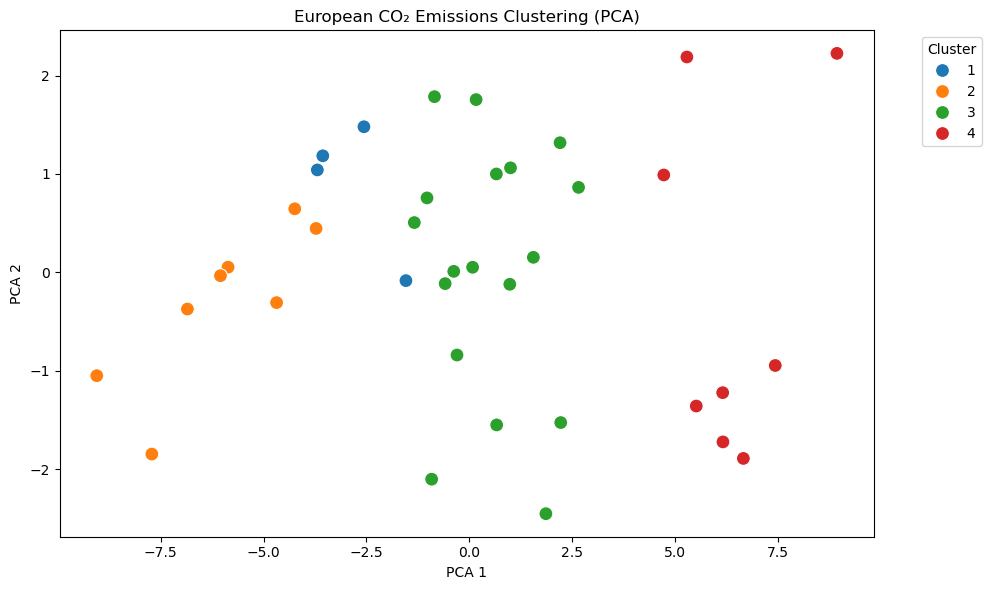

In [7]:
#  PCA visualization 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
df_wide['PCA1'] = pca_result[:, 0]
df_wide['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_wide, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('European CO₂ Emissions Clustering (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


We calculate average emissions per sector for each cluster (log-scaled). We visualize with a heatmap to identify sectoral emission patterns across clusters.

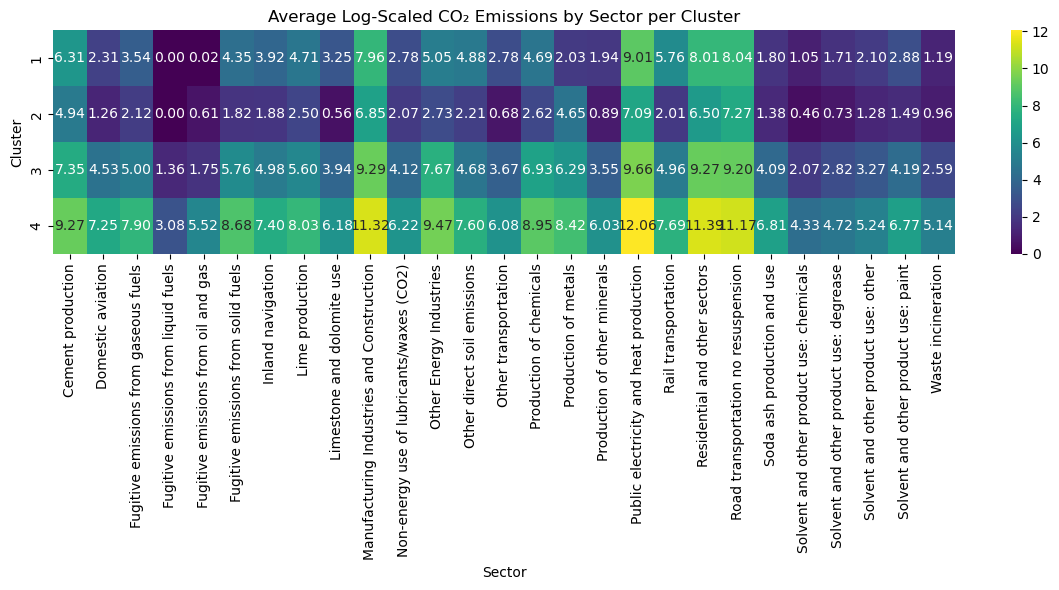

In [8]:
#  Cluster average emissions heatmap 
df_log['Cluster'] = df_wide['Cluster']
cluster_profiles = df_log.groupby('Cluster').mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles, cmap='viridis', annot=True, fmt=".2f", cbar=True)
plt.title('Average Log-Scaled CO₂ Emissions by Sector per Cluster')
plt.xlabel('Sector')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

After that we calculate relative sector contributions (%) within each cluster.This helps interpret dominant emission sectors per cluster.

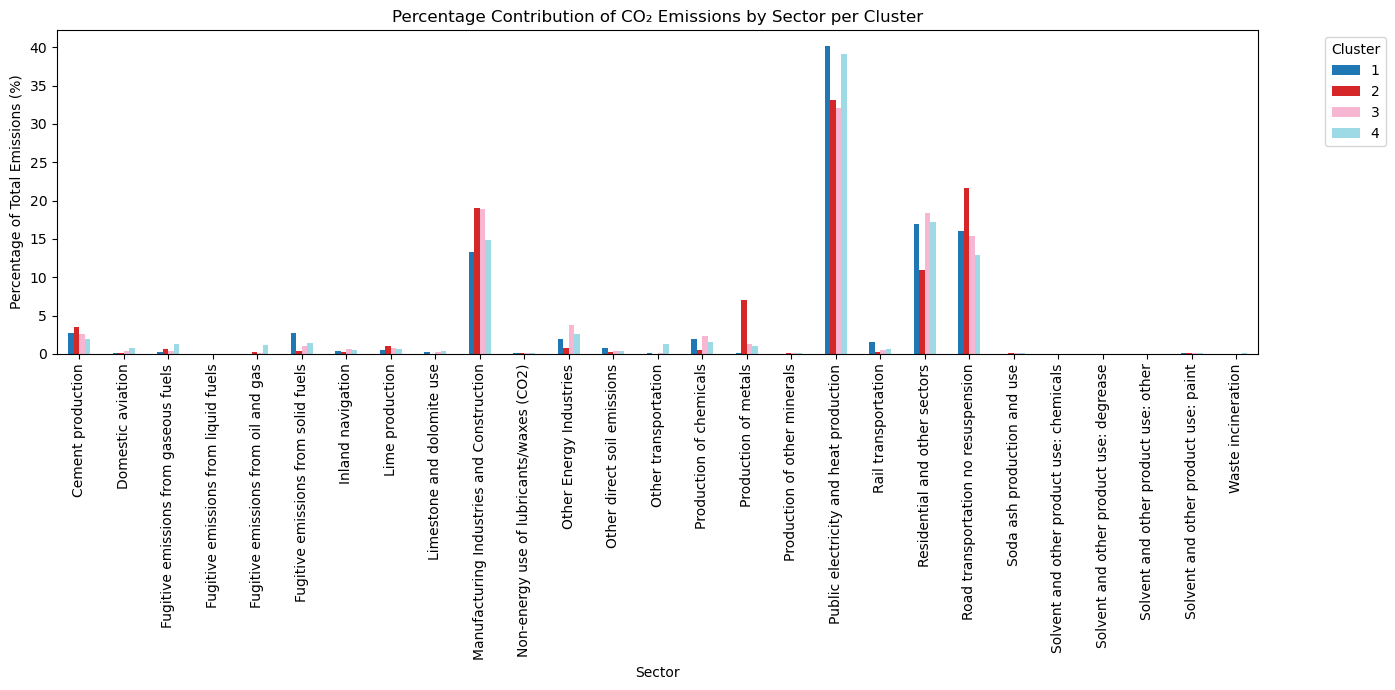

In [9]:
#  Analyze cluster similarities as sector percentages
cluster_means = df_wide.groupby('Cluster').mean().drop(columns=['PCA1', 'PCA2'])
cluster_totals = cluster_means.sum(axis=1)
cluster_percent = cluster_means.div(cluster_totals, axis=0) * 100
cluster_percent = cluster_percent.round(2)

# Barplot for cluster sector contribution
cluster_percent.T.plot(kind='bar', figsize=(14, 7), colormap='tab20')
plt.title('Percentage Contribution of CO₂ Emissions by Sector per Cluster')
plt.xlabel('Sector')
plt.ylabel('Percentage of Total Emissions (%)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [10]:
# Print cluster members
for cluster_id in sorted(df_wide['Cluster'].unique()):
    countries = df_wide[df_wide['Cluster'] == cluster_id].index.tolist()
    print(f"\n🌍 Cluster {cluster_id} ({len(countries)} countries):")
    print(", ".join(countries))
    
for cluster_id, row in cluster_percent.iterrows():
    top_sectors = row.sort_values(ascending=False).head(3)
    print(f"\nCluster {cluster_id} top sectors by % emissions:")
    for sector, pct in top_sectors.items():
        print(f" - {sector}: {pct}%")



🌍 Cluster 1 (4 countries):
Estonia, Ireland, Latvia, Lithuania

🌍 Cluster 2 (8 countries):
Albania, Bosnia and Herzegovina, Cyprus, Iceland, Luxembourg, Malta, North Macedonia, Slovenia

🌍 Cluster 3 (18 countries):
Austria, Belarus, Belgium, Bulgaria, Croatia, Czech Republic, Denmark, Finland, Greece, Hungary, Netherlands, Norway, Portugal, Romania, Serbia and Montenegro, Slovakia, Sweden, Switzerland

🌍 Cluster 4 (8 countries):
France, Germany, Italy, Poland, Russia, Spain, Ukraine, United Kingdom

Cluster 1 top sectors by % emissions:
 - Public electricity and heat production: 40.2%
 - Residential and other sectors: 16.98%
 - Road transportation no resuspension: 16.02%

Cluster 2 top sectors by % emissions:
 - Public electricity and heat production: 33.12%
 - Road transportation no resuspension: 21.59%
 - Manufacturing Industries and Construction: 19.01%

Cluster 3 top sectors by % emissions:
 - Public electricity and heat production: 32.14%
 - Manufacturing Industries and Construct

Based on these results our analysis seems logical because the clusters clearly group countries with similar economic structures and emission patterns. Cluster 1 includes smaller economies heavily reliant on centralized electricity production. Cluster 2 reflects transitional economies with emissions more evenly split between energy, transport, and industry. Cluster 3 contains mature, diversified economies with balanced emissions across all sectors. Cluster 4 consists of large, high-demand nations dominated by energy and residential emissions, confirming a logical and data-driven clustering approach.